In [1]:
import yfinance as yf

In [2]:
# !pip install tensorflow

In [3]:
stock = yf.Ticker("AAPL") 
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False) 


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2015-01-02 00:00:00-05:00,27.847500,27.860001,26.837500,27.332500,24.320433,212818400,0.0,0.0
2015-01-05 00:00:00-05:00,27.072500,27.162500,26.352501,26.562500,23.635283,257142000,0.0,0.0
2015-01-06 00:00:00-05:00,26.635000,26.857500,26.157499,26.565001,23.637505,263188400,0.0,0.0
2015-01-07 00:00:00-05:00,26.799999,27.049999,26.674999,26.937500,23.968962,160423600,0.0,0.0
2015-01-08 00:00:00-05:00,27.307501,28.037500,27.174999,27.972500,24.889904,237458000,0.0,0.0


In [5]:
data.shape

(2516, 8)

In [6]:
print(data.isnull().sum())


Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [7]:
df1 = data.reset_index()['Close']


In [8]:
df1

0        27.332500
1        26.562500
2        26.565001
3        26.937500
4        27.972500
           ...    
2511    258.200012
2512    259.019989
2513    255.589996
2514    252.199997
2515    250.419998
Name: Close, Length: 2516, dtype: float64

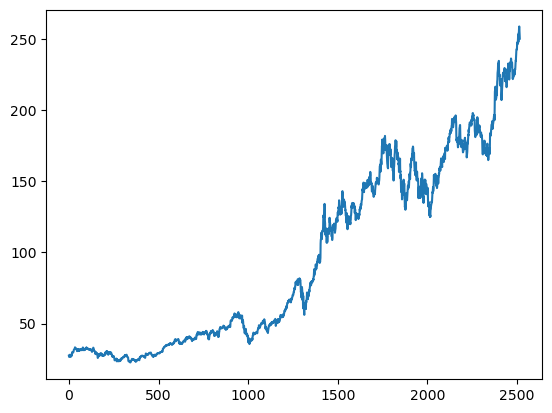

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
import numpy as np

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
print(df1)

[[0.02007952]
 [0.01682281]
 [0.01683339]
 ...
 [0.98549287]
 [0.9711549 ]
 [0.9636264 ]]


In [13]:
##splitting dataset into train and test split
training_size = int(len(df1)*0.8)
test_size = len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [14]:
training_size, test_size

(2012, 504)

In [15]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [16]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape)

(1911, 100)
(1911,)


(None, None)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input

In [25]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [21]:
# pip install numpy==1.19.5

In [28]:
model = Sequential()
# Add an Input layer to explicitly define the input shape
model.add(Input(shape=(100, 1)))  # Input shape: (time_steps, features)

# Add LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='Adam')

In [30]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0281 - val_loss: 0.0079
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 9.9735e-04 - val_loss: 0.0029
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 4.3041e-04 - val_loss: 0.0031
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 4.2827e-04 - val_loss: 0.0026
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 3.9664e-04 - val_loss: 0.0034
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 4.0073e-04 - val_loss: 0.0024
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 3.8978e-04 - val_loss: 0.0016
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 4.0462e-04 - val_loss: 0.0020
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 3.7104e-04 - val_loss: 0.0032
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 3.3130e-04 - val_loss: 0.0021
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 3.3780e-04 - val_loss: 0.0015
E

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 1.3853e-04 - val_loss: 0.0016
Epoch 66/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 1.4250e-04 - val_loss: 0.0021
Epoch 67/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 1.9882e-04 - val_loss: 3.5856e-04
Epoch 68/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 1.5741e-04 - val_loss: 3.4478e-04
Epoch 69/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 1.4330e-04 - val_loss: 8.1720e-04
Epoch 70/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 1.2797e-04 - val_loss: 5.5144e-04
Epoch 71/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 1.1537e-04 - val_loss: 0.0014
Epoch 72/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 1.3923e-04 - val_loss: 9.3313e-04
Epoch 73/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 1.1588e-04 - val_loss: 5.8865e-04
Epoch 74/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 1.1294e-04 - val_loss: 3.0189e-04
Epoch 75/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 1.3

In [32]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [34]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [36]:
import math
from sklearn.metrics import mean_squared_error

In [37]:
math.sqrt(mean_squared_error(y_train,train_predict))

20960.3619675837

In [38]:
math.sqrt(mean_squared_error(ytest,test_predict))

45963.28390783307

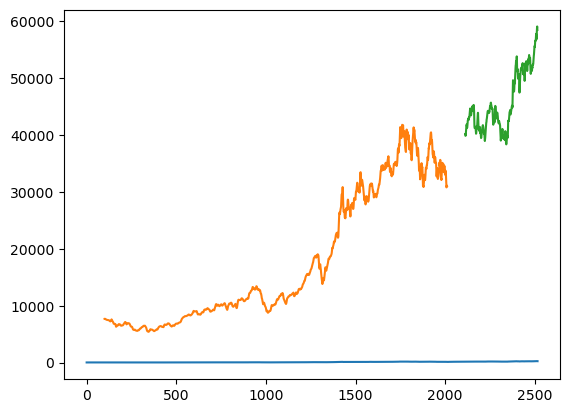

In [41]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Blue Line: Actual data (baseline).
# Orange Line: Training predictions.
# Green Line: Test predictions.

In [44]:
len(test_data)

504

In [45]:
x_input=test_data[404:].reshape(1,-1)
x_input.shape

(1, 100)

In [46]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [47]:
# demonstrate prediction for next days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9232755]
101
1 day input [0.8245184  0.84033673 0.84223998 0.85492846 0.86055369 0.85987696
 0.86249922 0.86203398 0.85412485 0.86389496 0.86533298 0.86892807
 0.86241468 0.87637195 0.87303068 0.84668096 0.83856035 0.84503146
 0.83843347 0.83881411 0.8354305  0.84621572 0.84668096 0.84553898
 0.81940075 0.82138855 0.83788361 0.87248083 0.86964708 0.86233007
 0.86613659 0.8619071  0.86677105 0.86791297 0.88994865 0.86123043
 0.86364121 0.85894647 0.86372581 0.8421131  0.85936944 0.87531458
 0.87319984 0.86689793 0.88275853 0.89354375 0.88478867 0.88635356
 0.89840764 0.90466727 0.902045   0.88047457 0.87967102 0.88322378
 0.89164042 0.89278241 0.87768315 0.85996157 0.84727309 0.84346651
 0.84955699 0.84646948 0.86660184 0.86440255 0.85285599 0.85285599
 0.85662023 0.86973168 0.85611271 0.8688858  0.86998544 0.87303068
 0.87100055 0.87671032 0.8893988  0.8986614  0.89811154 0.90826236
 0.91782099 0.93076323 0.93228585 0.93241273 0.93156684 0.94810417
 0.95241827 0.94700453 0.95322189 

10 day output [[0.70144516]]
11 day input [0.86533298 0.86892807 0.86241468 0.87637195 0.87303068 0.84668096
 0.83856035 0.84503146 0.83843347 0.83881411 0.8354305  0.84621572
 0.84668096 0.84553898 0.81940075 0.82138855 0.83788361 0.87248083
 0.86964708 0.86233007 0.86613659 0.8619071  0.86677105 0.86791297
 0.88994865 0.86123043 0.86364121 0.85894647 0.86372581 0.8421131
 0.85936944 0.87531458 0.87319984 0.86689793 0.88275853 0.89354375
 0.88478867 0.88635356 0.89840764 0.90466727 0.902045   0.88047457
 0.87967102 0.88322378 0.89164042 0.89278241 0.87768315 0.85996157
 0.84727309 0.84346651 0.84955699 0.84646948 0.86660184 0.86440255
 0.85285599 0.85285599 0.85662023 0.86973168 0.85611271 0.8688858
 0.86998544 0.87303068 0.87100055 0.87671032 0.8893988  0.8986614
 0.89811154 0.90826236 0.91782099 0.93076323 0.93228585 0.93241273
 0.93156684 0.94810417 0.95241827 0.94700453 0.95322189 0.95394089
 0.96624867 0.97656864 0.95360253 0.9609618  0.98084047 0.98413947
 0.99653191 1.         

19 day output [[0.5679942]]
20 day input [0.83881411 0.8354305  0.84621572 0.84668096 0.84553898 0.81940075
 0.82138855 0.83788361 0.87248083 0.86964708 0.86233007 0.86613659
 0.8619071  0.86677105 0.86791297 0.88994865 0.86123043 0.86364121
 0.85894647 0.86372581 0.8421131  0.85936944 0.87531458 0.87319984
 0.86689793 0.88275853 0.89354375 0.88478867 0.88635356 0.89840764
 0.90466727 0.902045   0.88047457 0.87967102 0.88322378 0.89164042
 0.89278241 0.87768315 0.85996157 0.84727309 0.84346651 0.84955699
 0.84646948 0.86660184 0.86440255 0.85285599 0.85285599 0.85662023
 0.86973168 0.85611271 0.8688858  0.86998544 0.87303068 0.87100055
 0.87671032 0.8893988  0.8986614  0.89811154 0.90826236 0.91782099
 0.93076323 0.93228585 0.93241273 0.93156684 0.94810417 0.95241827
 0.94700453 0.95322189 0.95394089 0.96624867 0.97656864 0.95360253
 0.9609618  0.98084047 0.98413947 0.99653191 1.         0.98549287
 0.9711549  0.9636264  0.92327547 0.89533472 0.86516076 0.83771652
 0.8134864  0.7919915

29 day output [[0.4954688]]
[[0.9232754707336426], [0.8953347206115723], [0.8651607632637024], [0.8377165198326111], [0.8134863972663879], [0.7919915318489075], [0.7724925875663757], [0.7542144060134888], [0.7365148067474365], [0.718980610370636], [0.7014451622962952], [0.6839484572410583], [0.6666687726974487], [0.6498480439186096], [0.633726179599762], [0.6184968948364258], [0.6042853593826294], [0.5911443829536438], [0.579065203666687], [0.5679941773414612], [0.5578507781028748], [0.5485435128211975], [0.539982259273529], [0.5320853590965271], [0.5247827172279358], [0.5180160999298096], [0.5117385387420654], [0.5059103965759277], [0.500497579574585], [0.49546879529953003]]


In [48]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [49]:
import matplotlib.pyplot as plt

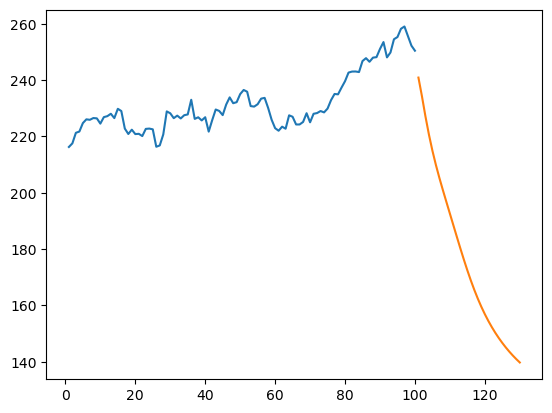

In [52]:
plt.plot(day_new,scaler.inverse_transform(df1[2416:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [51]:
len(df1)

2516